In [1]:
import numpy as np
import pandas as pd
import lxml.etree as etree
import sqlite3 as sql
from process import *
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

In [3]:
data = pd.read_csv('../data/prem_data_elo.csv', index_col = 'Unnamed: 0')
data.head()

,match_api_id,league_id,date,home_team_api_id,home_team_name,away_team_api_id,away_team_name,home_team_goal,away_team_goal,home_team_foul_reason_from_behind,...,away_team_card_reason_pushing,home_team_card_reason_diving,away_team_card_reason_diving,home_team_card_reason_hands,away_team_card_reason_hands,home_team_card_reason_Removing Shirt,away_team_card_reason_Removing Shirt,result,home_elo,away_elo
0,489044,1729,2008-08-16 00:00:00,8472,Sunderland,8650,Liverpool,0,2,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0
1,489045,1729,2008-08-16 00:00:00,8654,West Ham United,8528,Wigan Athletic,2,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0
2,489047,1729,2008-08-16 00:00:00,8668,Everton,8655,Blackburn Rovers,2,12,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0
3,489048,1729,2008-08-16 00:00:00,8549,Middlesbrough,8586,Tottenham Hotspur,2,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0
4,489049,1729,2008-08-16 00:00:00,8559,Bolton Wanderers,10194,Stoke City,3,4,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0


In [384]:
def transform_target(X, y, class_labels = ['W', 'D', 'L'], weight = True, down_sample = True):
    if weight and down_sample:
        size = np.min(np.unique(pd.concat([y[y == x] for x in class_labels]), return_counts = True)[1])
        idx = [np.random.choice(y[y == x].index.values, size = size) for x in class_labels]
        down_idx = np.concatenate(idx)
        weights = {}
        for class_ in class_labels:
            weights[class_] = y[y == class_].shape[0]/size

        return X.iloc[down_idx], y[down_idx], weights
    elif weight and not down_sample:
        size = np.max(np.unique(pd.concat([y[y == x] for x in class_labels]), return_counts = True)[1])
        weights = {}
        for i, class_ in enumerate(class_labels):
            weights[class_] = size/y[y == class_].shape[0]
        return X, y, weights
    else:
        y_ = pd.concat([y[y == x] for x in class_labels])
        return X.iloc[y_.index], y_, None

def RFpipe(weights = None, params = {}):
    return Pipeline(steps = [
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(class_weight = weights, **params))
    ])

def Logitpipe(weights = None, params = {}):
    return Pipeline(steps = [
        ('scaler', StandardScaler()),
        ('logit', LogisticRegression(class_weight = weights, **params))
    ])

def train_test(func, X, y, weight, down_sample, class_labels = ['W', 'D', 'L'], cm = False, seed = None):
    if seed != None:
        np.random.seed(seed)
    X_ds, y_ds, weights = transform_target(X, y, class_labels = class_labels, weight = weight, down_sample = down_sample)
    X_train, X_test, y_train, y_test = train_test_split(X_ds, y_ds, test_size = 0.2, stratify = y_ds)

    print('>>>Preprocess done', weights)

    clf = func(weights = weights).fit(X_train, y_train)
    print(metric_suite(clf, X_train, y_train, labels = class_labels, cm = cm))
    print(metric_suite(clf, X_test, y_test, labels = class_labels, cm = cm))

In [367]:
X = data[data.columns[9:]].drop(
    ['result', 'home_elo', 'away_elo'],
axis = 1)
y = data['result']

### Random Forest

In [376]:
train_test(RFpipe, X, y, weight = False, down_sample = False, cm = False)

>>>Preprocess done None
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.993994   0.988060  0.993994  0.991018      666
1      D  0.972868   0.996032  0.972868  0.984314      258
2      L  0.997817   0.996366  0.997817  0.997091     1374
3  Total  0.993908   0.993921  0.993908  0.993896     2298
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.323353   0.593407  0.323353  0.418605      167
1      D  0.030769   0.400000  0.030769  0.057143       65
2      L  0.912536   0.653445  0.912536  0.761557      343
3  Total  0.641739   0.607357  0.641739  0.582322      575


In [377]:
train_test(RFpipe, X, y, weight = True, down_sample = False, cm = False)

>>>Preprocess done {'W': 2.061224489795918, 'D': 5.315789473684211, 'L': 1.0}
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.989489   0.993967  0.989489  0.991723      666
1      D  0.996124   0.969811  0.996124  0.982792      258
2      L  0.994905   0.997810  0.994905  0.996356     1374
3  Total  0.993473   0.993553  0.993473  0.993490     2298
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.239521   0.481928  0.239521  0.320000      167
1      D  0.015385   0.142857  0.015385  0.027778       65
2      L  0.909621   0.643299  0.909621  0.753623      343
3  Total  0.613913   0.539859  0.613913  0.545632      575


In [393]:
train_test(RFpipe, X, y, weight = True, down_sample = True, cm = False)

>>>Preprocess done {'W': 2.5789473684210527, 'D': 1.0, 'L': 5.315789473684211}
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.996124   0.996124  0.996124  0.996124      258
1      D  0.992248   1.000000  0.992248  0.996109      258
2      L  1.000000   0.992337  1.000000  0.996154      259
3  Total  0.996129   0.996149  0.996129  0.996129      775
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.676923   0.586667  0.676923  0.628571       65
1      D  0.646154   0.677419  0.646154  0.661417       65
2      L  0.609375   0.684211  0.609375  0.644628       64
3  Total  0.644330   0.649253  0.644330  0.644874      194


In [386]:
train_test(RFpipe, X, y, weight = False, down_sample = False, class_labels = ['W', 'L'], cm = False)

>>>Preprocess done None
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.995495   0.994003  0.995495  0.994749      666
1      L  0.997089   0.997815  0.997089  0.997452     1374
2  Total  0.996569   0.996570  0.996569  0.996569     2040
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.323353   0.568421  0.323353  0.412214      167
1      L  0.880466   0.727711  0.880466  0.796834      343
2  Total  0.698039   0.675551  0.698039  0.670890      510


In [394]:
train_test(RFpipe, X, y, weight = True, down_sample = False, class_labels = ['W', 'L'], cm = False)

>>>Preprocess done {'W': 2.061224489795918, 'L': 1.0}
   Class  Accuracy  Precision    Recall        F1  Support
0      W  1.000000   0.982301  1.000000  0.991071      666
1      L  0.994905   0.999269  0.994905  0.997082     1374
2  Total  0.994343   0.993729  0.996569  0.995120     2040
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.245509   0.418367  0.245509  0.309434      167
1      L  0.865889   0.629237  0.865889  0.728834      343
2  Total  0.587826   0.560188  0.662745  0.591501      510


>>>Preprocess done {'W': 1.0, 'L': 2.061224489795918}


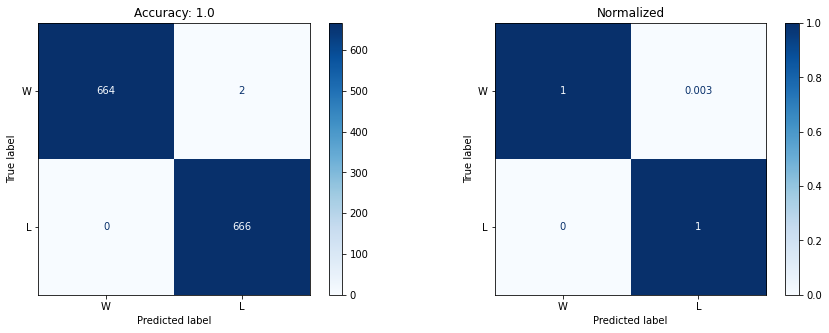

   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.996997   1.000000  0.996997  0.998496      666
1      L  1.000000   0.997006  1.000000  0.998501      666
2  Total  0.998498   0.998503  0.998498  0.998498     1332


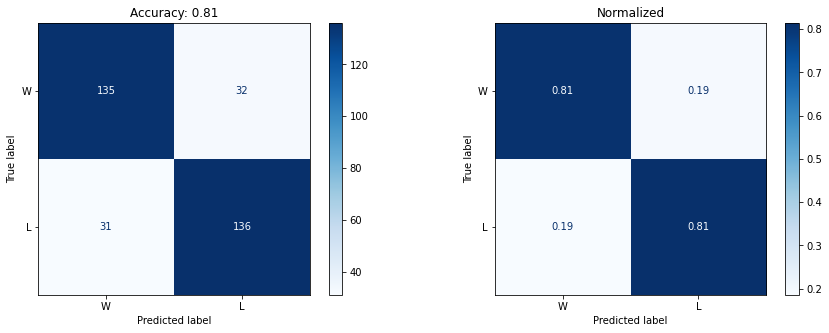

   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.808383   0.813253  0.808383  0.810811      167
1      L  0.814371   0.809524  0.814371  0.811940      167
2  Total  0.811377   0.811388  0.811377  0.811376      334


In [397]:
train_test(RFpipe, X, y, weight = True, down_sample = True, class_labels = ['W', 'L'], cm = True, seed = 144)

In [290]:
grid = {
    'rf__max_depth' : list(range(10, 90, 20)) + [None],
    'rf__min_samples_leaf' : [2, 5, 10],
    'rf__min_samples_split' : [2, 5, 10],
    'rf__class_weight' : [weights]
}

cv = GridSearchCV(RFpipe(weights), grid, cv = 10, return_train_score  = True, n_jobs = -1).fit(X_ds, y_ds)
cv_res = pd.DataFrame(cv.cv_results_)

In [309]:
val = [RFpipe(weights).set_params(**param).fit(X_train, y_train).score(X_test, y_test) for param in tqdm(cv_res['params'])]

  0%|          | 0/45 [00:00<?, ?it/s]

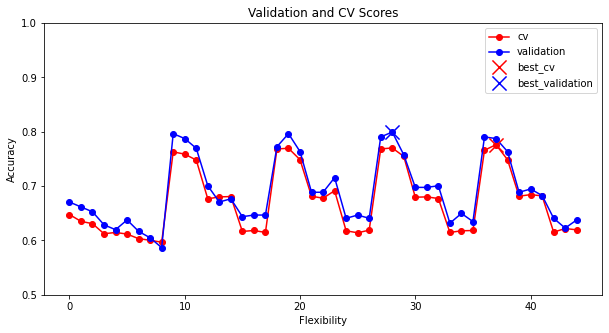

In [362]:
fig, axs = plt.subplots(figsize = (10,5))
plt.plot(cv_res['mean_test_score'], '-o', zorder = 0, color = 'red')
plt.plot(val, '-o', zorder = 1, color = 'blue')
plt.scatter(37,0.776, marker = 'x', s = 200, c = 'r', zorder = 2)
plt.scatter(28,0.7994, marker = 'x', s = 200, c = 'b', zorder = 3)

plt.legend(labels = ['cv', 'validation', 'best_cv', 'best_validation'])
plt.ylim([0.5, 1])
plt.title('Validation and CV Scores')
plt.xlabel('Flexibility')
plt.ylabel('Accuracy')
plt.show()

### Logistic Regression

In [374]:
train_test(Logitpipe, X, y, weight = True, down_sample = False, cm = False)

>>>Preprocess done None
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.358859   0.538288  0.358859  0.430631      666
1      D  0.007752   0.400000  0.007752  0.015209      258
2      L  0.887191   0.659275  0.887191  0.756438     1374
3  Total  0.635335   0.595102  0.635335  0.578795     2298
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.317365   0.504762  0.317365  0.389706      167
1      D  0.000000   0.000000  0.000000  0.000000       65
2      L  0.886297   0.650964  0.886297  0.750617      343
3  Total  0.620870   0.534914  0.620870  0.560944      575


In [ ]:
X_ds, y_ds, weights = transform_target(X, y, weight = False, down_sample = False)
X_train, X_test, y_train, y_test = train_test_split(X_ds, y_ds, test_size = 0.2, stratify = y_ds)

print('>>>Preprocess done', weights)

clf = RFpipe(weights = weights).fit(X_train, y_train)
print(metric_suite(clf, X_train, y_train, cm = False))
print(metric_suite(clf, X_test, y_test, cm = False))